In [39]:
import PIL.Image
import os
import sys
sys.path.append('..') if '..' not in sys.path else print('Already included')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from utils.augment import RandomAugmentor

import torch
from torchvision import transforms as transforms
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import torchvision.transforms.functional as F

Already included


## Augmentation Upsampling

In [40]:
rand_augment = RandomAugmentor(apply_n=3)

In [41]:
rand_augment._get_transformation()

Compose(
    GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
    RandomInvert(p=0.5)
    Resize(size=128, interpolation=bilinear, max_size=None, antialias=None)
)

In [42]:
'_'.join(rand_augment.current_transforms)

'blur_rinv_orig'

In [43]:
df = pd.read_csv('../data/labels.csv')
train = df[df['set'] == 'train']
train.head(2)

,image,set,label
1,100184900.png,train,Rost/Strassenrost
2,100034700.png,train,Rost/Strassenrost


In [44]:
augmentations = list(rand_augment.augmentations.keys())
augmentations

['orig',
 'jit',
 'fliph',
 'flipv',
 'pers',
 'rot',
 'blur',
 'raff',
 'rcrop',
 'rinv',
 'rshrp',
 'rcont']

In [45]:
def augment_pairs_combination(steps, size):
    resample_times = 20000
    A = np.array([np.random.choice(a=steps, size=size, replace=False) for _ in range(resample_times)])
    A[:].sort()
    A = np.unique(A, axis=0)
    np.random.shuffle(A)
    return A

def augment_pairs_variation(steps, size):
    resample_times = 10000
    A = np.array([np.random.choice(a=steps, size=size, replace=False) for _ in range(resample_times)])
    A = np.unique(A, axis=0)
    np.random.shuffle(A)
    return A

In [142]:
transformation_df = pd.DataFrame(data={'image': [], 
                                       'transforms': []})
max_count = 500

In [143]:
upsample_diff = max_count  #- train.groupby('label').count()['image'].sort_values()

In [144]:
augment_combos = augment_pairs_combination(augmentations, 3)
augment_combos = ['_'.join(combo) for combo in augment_combos]

for ctype in tqdm(train['label'].unique()):
    image_ids = train.loc[train['label'] == ctype, 'image'].to_numpy()
    print(ctype, '--', upsample_diff)
    
    # Get repeated index samples until size of upsample diff is reached
    sample_idx = np.repeat(a=image_ids, 
                           repeats=(upsample_diff // image_ids.shape[0]) +1)[:upsample_diff]
    sample_idx = np.random.permutation(sample_idx)
    
    
    img_augmentations = np.repeat(a=img_augmentations, 
                                  repeats=(upsample_diff // image_ids.shape[0]) +1)
    img_augmentations = np.random.permutation(augment_combos)[:upsample_diff]
       
    # Get upsample combinations
    img_augmentations = np.random.choice(augment_combos, size=upsample_diff, replace=True)
    
    #np.array(list(zip(sample_idx, img_augmentations)))
    
    tmp = pd.DataFrame({'image': sample_idx, 'transforms': img_augmentations})
    transformation_df = pd.concat([transformation_df, tmp], axis=0)

  0%|          | 0/13 [00:00<?, ?it/s]

Rost/Strassenrost -- 500
Vollguss/Handgriff geschlossen -- 500
Gussbeton/Pickelloch belueftet -- 500
Vollguss/Pickelloch geschlossen -- 500
Vollguss/Handgriff geschlossen, verschraubt -- 500
Gussbeton/Pickelloch geschlossen -- 500
Gussbeton/Handgriff mitte -- 500
Vollguss/Pickelloch belueftet -- 500
Rost/Einlauf rund -- 500
Gussbeton/Handgriff seitlich -- 500
Rost/Strassenrost gewoelbt -- 500
Vollguss/Aufklappbar -- 500
Andere/- -- 500


In [145]:
transformation_df.shape

(6500, 2)

In [146]:
transformation_df = transformation_df.drop_duplicates()
transformation_df.shape

(6329, 2)

In [147]:
transformation_df.head(5)

,image,transforms
0,100130800.png,raff_rcrop_rshrp
1,100072900.png,jit_rinv_rshrp
2,100091100.png,flipv_jit_rinv
3,100072500.png,pers_rcont_rot
4,100083500.png,orig_pers_rcrop


In [148]:
tmp = pd.merge(left=transformation_df, right=train, how='left', left_on='image', right_on='image')
tmp

,image,transforms,set,label
0,100130800.png,raff_rcrop_rshrp,train,Rost/Strassenrost
1,100072900.png,jit_rinv_rshrp,train,Rost/Strassenrost
2,100091100.png,flipv_jit_rinv,train,Rost/Strassenrost
3,100072500.png,pers_rcont_rot,train,Rost/Strassenrost
4,100083500.png,orig_pers_rcrop,train,Rost/Strassenrost
...,...,...,...,...
6324,100050800.png,raff_rinv_rot,train,Andere/-
6325,100086400.png,jit_rcont_rot,train,Andere/-
6326,100138300.png,blur_raff_rinv,train,Andere/-
6327,100070200.png,flipv_orig_pers,train,Andere/-


In [149]:
tmp['label'].value_counts()

Vollguss/Handgriff geschlossen                 500
Rost/Strassenrost                              499
Vollguss/Pickelloch geschlossen                499
Gussbeton/Pickelloch belueftet                 498
Gussbeton/Pickelloch geschlossen               497
Vollguss/Handgriff geschlossen, verschraubt    496
Andere/-                                       493
Vollguss/Pickelloch belueftet                  492
Rost/Einlauf rund                              491
Gussbeton/Handgriff seitlich                   478
Gussbeton/Handgriff mitte                      474
Rost/Strassenrost gewoelbt                     466
Vollguss/Aufklappbar                           446
Name: label, dtype: int64

In [150]:
selected_type = tmp['label'].value_counts().index[1]

In [151]:
A = tmp.loc[tmp['label'] == selected_type, 'image'].unique()
B = train.loc[train['label'] == selected_type,  'image'].unique()
np.isin(B, A).shape[0] - np.isin(B, A).sum()

212

In [152]:
tmp.head(2)

,image,transforms,set,label
0,100130800.png,raff_rcrop_rshrp,train,Rost/Strassenrost
1,100072900.png,jit_rinv_rshrp,train,Rost/Strassenrost


In [153]:
tmp.isnull().sum()

image         0
transforms    0
set           0
label         0
dtype: int64

In [154]:
tmp.loc[tmp['transforms'].isnull()]

,image,transforms,set,label


In [155]:
tmp.loc[1, 'transforms'] == False

False

In [156]:
tmp = tmp.fillna(value='0')

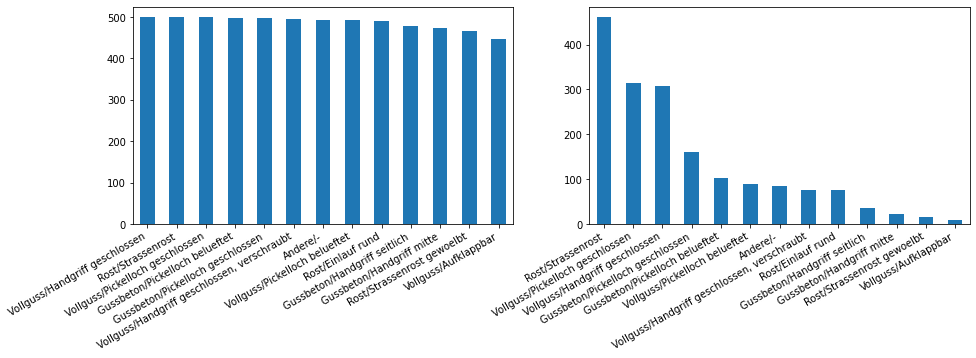

In [157]:
plt.subplots(figsize=(15, 4))

plt.subplot(1,2,1)
tmp.drop_duplicates().loc[:,'label'].value_counts().plot(kind='bar')
plt.xticks(rotation=30, ha='right')

plt.subplot(1,2,2)
train['label'].value_counts().plot(kind='bar')
plt.xticks(rotation=30, ha='right')

plt.show()

**Beschreibung:**

Aufgrund der möglichen permutierten Transformationen und kann es sein, dass in sehr kleinen Klassen z.B. Rost/Strassenrost oder Vollguss/Aufklappbar einige Redundanzen innerhalb der Transformationen zu finden sind. Deshalb kann hier nicht auf das genau gleiche Niveau gesamplet werden.

In [158]:
transformed_samples = []
for _ in range(20):
    img_id = tmp.sample(1)['image'].iloc[0]
    img = PIL.Image.open(f'../data/train/{img_id}')
    img = rand_augment.transform_given_key(img, tmp.loc[tmp['image'] == img_id, 'transforms'].iloc[0].split('_'))
    img = transforms.Compose([transforms.Resize(128), transforms.ToTensor()])(img)
    transformed_samples.append(img)

In [29]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(12, 12))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

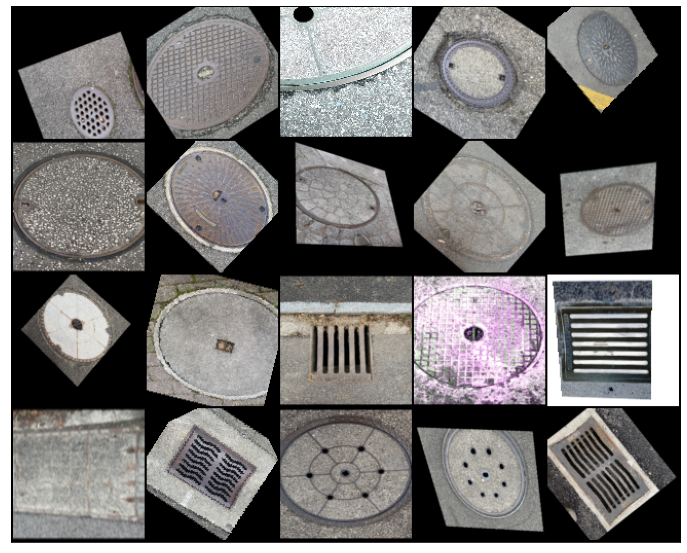

In [30]:
show(make_grid(transformed_samples, nrow=5))

## Join val test data

In [ ]:
val_images = os.listdir('../data/val/')
test_images = os.listdir('../data/test/')
label_df = pd.read_csv('../data/labels.csv')

In [ ]:
val_images = label_df[label_df['image'].isin(val_images)]
test_images = label_df[label_df['image'].isin(test_images)]

In [ ]:
val_images['transforms'] = '0'
test_images['transforms'] = '0'

In [ ]:
df.shape, val_images.shape, test_images.shape

In [ ]:
tmp = pd.concat([tmp, val_images, test_images], axis=0).shape

## Save

In [35]:
tmp.to_csv('../data/trans_labels.csv', index=False)